--------config.ini file found at  C:\Users\larmi\projects\skill-skeleton/config.ini
PDF resume file:  Consultant-1.pdf
NER type: Trained NER
Scenario B: Improve existing profile with missing skills
Show displacy skills from PDF:  True
Recommender type:  cypher-skills
Classification type: Python code



Skills found in the PDF resume:  ['powerpoint', 'word', 'project management', 'excel']


alt.Chart(...)

                 Profile matching scores                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Profile        ┃ Count ┃ Max ┃ Coverage ┃ Total score ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Data Analyst   │ 4     │ 96  │ 4.1667   │ 113.5135    │
│ Data Engineer  │ 4     │ 148 │ 2.7027   │ 50.9615     │
│ Data Scientist │ 2     │ 99  │ 2.0202   │ 25.8824     │
└────────────────┴───────┴─────┴──────────┴─────────────┘

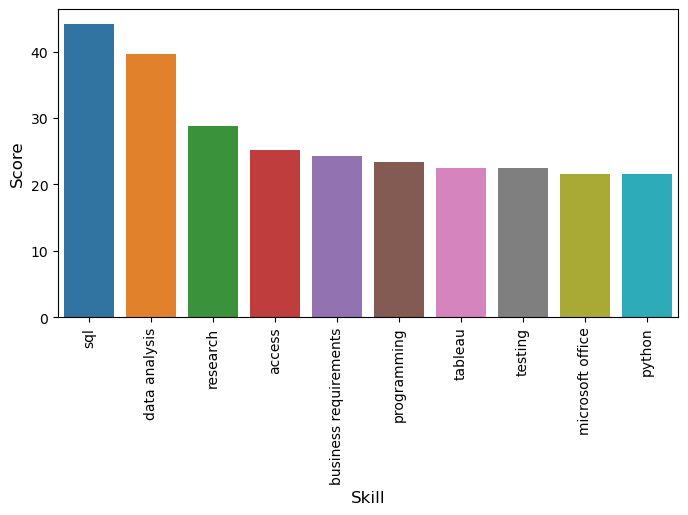


Chosen profile:  Data Analyst
Skills to learn based on scenario:  sql data analysis research access business requirements programming tableau testing microsoft office python



                                                Recommended courses                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Title                                         ┃ URL                                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Introduction to Artificial Intelligence, Mac… │ https://www.vaia.be/en/courses/introduction-to-artificial-inte… │
│ Hands-on CasADi course on optimal control     │ https://www.vaia.be/en/courses/praktijkgerichte-casadi-cursus-… │
│ Computer Vision in Surgery                    │ https://www.vaia.be/en/courses/summer-school-computer-vision-i… │
│ Keeping things private: Exploring open-sourc… │ https://www.vaia.be/en/courses/keeping-things-private-explorin… │
│ A deep dive into reinforcement learning       │ https://www.vaia.be/en/courses/a-deep-dive-into-reinforcement-… │
└───────────────────────────────────────────────┴─────────────────────────────────────────────────────────────────┘

2024-05-01 21:27:23,359 | INFO | app.ipynb finished running


In [10]:
import spacy
import pickle
import sys  
from spacy.util import filter_spans
import pandas as pd
import os
from dotenv import load_dotenv
import typer
from rich.table import Table
from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore') 

sys.path.insert(1, 'C:/Users/larmi/projects/skill-skeleton/')
sys.path.insert(2, 'C:/Users/larmi/projects/skill-skeleton/utils/')
sys.path.insert(3, 'C:/Users/larmi/projects/skill-skeleton/utils/neo4j/')
sys.path.insert(4, 'C:/Users/larmi/projects/skill-skeleton/models/')

from connection import Neo4jConnection
import recommender_model
import classification_model
import pdf_util
import kb_util
import logger_util
import monitor_util
import setup
import query
import graph

from spacy import displacy

import altair as alt


###################################################################################################################################
def read_resume(app_config, filename: str) -> str:
    
    file_content = pdf_util.read_PDF('%s/data/cv/%s' % (app_config["root"],filename))   
    
    #Remove punctuation from the data
    file_content = kb_util.fix(file_content)
        
    return file_content


def extract_skills(data: str, conn: Neo4jConnection, nlp: any, loaded_matcher: any, NER_type: str, show_displacy:bool) -> pd.DataFrame:


    #Evaluate A - Ruler version
    if NER_type == 'A':       
        doc = nlp(data)
        if show_displacy: 
            displacy.render(doc, style="ent", jupyter=True)
        tags = list(ent.text.lower() for ent in doc.ents if ent.label_ == 'SKILL')
           
    #Evaluate   - Matcher version before NET Model is trained
    if NER_type == 'B':
        doc = nlp(data)
        matches = loaded_matcher(doc, as_spans=True)
        filtered_spans =spacy.util.filter_spans(matches)
        doc.ents = filter_spans(filtered_spans)              
        if show_displacy:
            displacy.render(doc, style="ent", jupyter=True)
        tags = list(ent.text.lower() for ent in doc.ents if ent.label_ == 'SKILL')
        
    #Evaluate C - Trained annoted model   
    if NER_type == 'C':
        doc = nlp(data)
        if show_displacy:
            displacy.render(doc, style="ent", jupyter=True)
        tags = list(ent.text.lower() for ent in doc.ents if ent.label_ == 'SKILL')    
        
    #Evaluate D - GPT
    #TODO Upgrade account
    if NER_type == 'D':
        """
        import openai 

        # assigning API KEY to initialize openai environment 
        openai.api_key = ''  


        MODEL = "gpt-3.5-turbo"
        
        completion = openai.chat.completions.create(
            model=MODEL,   
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "Perform NER on the following sentence: 'In Brussels I worked with Bill Gates on Big Data, NLP, Functional, Business and Technical Analysis with a LLM for sourcing data flows into a Data Lake. Working within an Investments context. Working with IBM BI and Data Warehousing technologies.' and return it as JSON and indicate the start and end indexes of the entities. Also name the resulting array 'Entities'. Also add the original sentence as the first element in the response. Only include the entities that are  part of the machien learning domain"}   
            ]
        )
        print(completion.choices[0].message.content)
        
        """
        
        response = {
        "Original_Sentence": "In Brussels I worked with Bill Gates on Big Data, NLP, Functional, Business and Technical Analysis with a LLM for sourcing data flows into a Data Lake. Working within an Investments context. Working with IBM BI and Data Warehousing technologies.",
        "Entities": [
            {
            "Entity": "Big Data",
            "Start_Index": 35,
            "End_Index": 43
            },
            {
            "Entity": "NLP",
            "Start_Index": 45,
            "End_Index": 47
            },
            {
            "Entity": "Data Lake",
            "Start_Index": 99,
            "End_Index": 107
            }
        ]
        }
        
        tags = [x['Entity'].lower() for x in response['Entities']]
        
    no_duplicates_list = list(set(tags))  
    
    return no_duplicates_list


def cast_item(item: any) -> str:
    if isinstance(item, float):
        item = round(item, 4)
    return str(item)


def print_courses(recommended_courses:pd.DataFrame) -> None:
    
    table = Table(title="Recommended courses")
    table.add_column("Title", style="white", no_wrap=True)    
    table.add_column("URL", style="white", no_wrap=True)   
    for index, row in recommended_courses.iterrows():
        table.add_row(row['title'], row['url'])
    console = Console()
    console.print(table)
    

def print_profiles(profiles:pd.DataFrame, classification_type:str) -> None:      
    
    table = Table(title="Profile matching scores")
    table.add_column("Profile", style="white", no_wrap=True)    
    
    if classification_type != 'B':
        table.add_column("Count", style="white")   
        table.add_column("Max", style="white")  
        table.add_column("Coverage", style="white")  
        table.add_column("Total score", style="white")  
        
        for index, row in profiles.iterrows():
            table.add_row(row['profile'], cast_item(row['count']), cast_item(row['max']), cast_item(row['coverage']), cast_item(row['total_score']))
        
        df = pd.melt(profiles, id_vars=['profile'], value_vars=['count', 'max', 'coverage', 'total_score'], var_name='Genre', value_name='Score')
    
        chart = alt.Chart(df).mark_bar().encode(
            column=alt.Column('Genre'),
            x=alt.X('profile'),
            y=alt.Y('Score'),
            color=alt.Color('profile', scale=alt.Scale(range=['#EA98D2', '#659CCA', '#F6C85F']))
                ).configure_view(
                    strokeWidth=0.0,
                )

        chart.show()

    else:
        table.add_column("skills", style="white")  
        for index, row in profiles.iterrows():
            table.add_row(row['profile'],row['skills'])

    console = Console()
    console.print(table)
   

def print_app_config(PDF_resume: str,NER_type: str,scenario: str,to_be_profile: str,show_displacy: bool,recommender_type: str,classification_type: str) -> None:
    
    print(f'PDF resume file: ', PDF_resume) 
        
    if NER_type == 'A':
        print('NER type: Ruler')
    if NER_type == 'B':
        print('NER type: Matcher')
    if NER_type == 'C':
        print('NER type: Trained NER')  
    if NER_type == 'D': 
        print('NER type: Open AI')
    
    if scenario == 'A':
        print('Scenario A: Improve existing profile with current skills')
    if scenario == 'B':
        print('Scenario B: Improve existing profile with missing skills')
    if scenario == 'C':
        print(f'Scenario C: Become a: ' , to_be_profile)
        
    print(f'Show displacy skills from PDF: ', show_displacy)
   
    print(f'Recommender type: ', recommender_type)    
   
    if classification_type == 'A1':
        print(f'Classification type: Python code')
    if classification_type == 'A2':
        print(f'Classification type: Cypher query')
    if classification_type == 'B':
        print(f'Classification type: Text classification')
   
    print("====================================================================================================")
    print()


def missing_skills(conn: Neo4jConnection, profiles: any, my_skills: list) -> tuple[str, pd.DataFrame]:
        
    if type(profiles) is not pd.DataFrame:
        chosen_profile = profiles[0]
    else:
        chosen_profile = profiles.iloc[0]['profile']    

    to_learn = query.get_remaining_skills_by_profile(conn, chosen_profile, my_skills)
         
    return chosen_profile, to_learn


def config_app(NER_type: str) -> tuple[any, logger_util.Logger_util, monitor_util.Monitor, Neo4jConnection, any, any]:
    # Load the stored environment variables ########################################################################
    load_dotenv()

    app_config, app_logger, monitor, conn, nlp, loaded_matcher = None, None, None, None, None, None

    # Setup #########################################################################################################

    config = setup.read_config()
    app_config = config["APP"]
    log_config = config["LOG"]
    monitor_config = config["MONITOR"]

    app_logger = logger_util.Logger_util(log_config["file"])
    monitor = monitor_util.Monitor(monitor_config["file"])

    conn = Neo4jConnection(uri=os.getenv("DB_URI"), 
                        user=os.getenv("DB_USERNAME"),              
                        pwd=os.getenv("DB_PASSWORD"))
    
    # Load the NER model    
    if NER_type == 'A':
        NER_model = 'ruler_model'
        nlp = spacy.load("%s/models/NER/%s" % (app_config["root"],NER_model))
    
    if NER_type == 'B':
        nlp = spacy.load("en_core_web_sm")
        nlp.vocab.strings.add('SKILL')
        filename = "%s/models/NER/finalized_matcher.pickle" % (app_config["root"])
        loaded_matcher = pickle.load(open(filename, 'rb'))    
    
    if NER_type == 'C':
        NER_model = 'model-best-C_PT_E_HP_P'
        nlp = spacy.load("%s/models/NER/%s" % (app_config["root"],NER_model))
    
      
    
    return app_config, app_logger, monitor, conn, nlp, loaded_matcher


def main(PDF_resume:str, NER_type:str = 'C', scenario:str = 'B', to_be_profile:str = 'Data Analyst', show_displacy:bool = 'True', recommender_type:str = 'cypher-skills', classification_type:str = 'A1') -> None:  
    """Read a PDF resume and extract skills. Then, based on the scenario, recommend courses to improve the skills.

    Args:
      PDF_resume: The PDF resume file from data/cv directory.
      NER_type: The NER type to use: A = Ruler / B = Matcher / C = Trained NER / D = Open AI
      scenario: The application scenario: A = Improve existing profile with current skills / B = Improve existing profile with missing skills / C = Become a specific profile
      to_be_profile: The profile to become for scenario C: Data Analyst / Data Scientist / Data Engineer
      show_displacy: Show displacy skills from PDF.
      recommender_type: The recommender type to use: tfidf-data / tfidf-skills / cypher-skills
      classification_type: The classification type to use: A1 = Python code / A2 = Cypher query / B =  text classification

    Returns:
      None

    Raises:
      Exception: If any error occurs.
    """
    try:

        #Configure application
        app_config, app_logger, monitor, conn, nlp, loaded_matcher  = config_app(NER_type)
        print_app_config(PDF_resume,NER_type,scenario,to_be_profile,show_displacy,recommender_type,classification_type)

        # Read resume and extract skills
        data = read_resume(app_config, PDF_resume)

        # Extract skills
        skills = extract_skills(data, conn, nlp, loaded_matcher, NER_type, show_displacy)

        if len(skills) == 0:
            print('No skills found in the resume')
        else:
            print(f'Skills found in the PDF resume: ', skills)    
            
            
            if scenario == 'A' or scenario == 'B':
                # Define profile
                if classification_type == 'A1':
                    profiles = classification_model.profiles_A1(conn, skills)
                if classification_type == 'A2':           
                    profiles = classification_model.profiles_A2(conn, skills)     
                if classification_type == 'B':
                    profiles = recommender_model.profiles_B(conn, skills)          
                    
            else:
                profiles = [to_be_profile]

            if profiles is None:
                print('No profile found')
            else:        
            
                print_profiles(profiles,classification_type) 
                
                # Search for missing skills for the profile
                if scenario == 'B' or scenario == 'C':
                    chosen_profile, df_skills_to_learn = missing_skills(conn, profiles, skills)
                    graph.show_skill_score_graph(df_skills_to_learn)
                    skill_to_learn = ' '.join([x for x in df_skills_to_learn['skill']])
                else:
                    chosen_profile = profiles.iloc[0]['profile']
                    skill_to_learn = ' '.join([x for x in skills])   
                
                print()
                print(f'Chosen profile: ', chosen_profile)
                
                print(f'Skills to learn based on scenario: ', skill_to_learn)
                print()
                
                if recommender_type == 'tfidf-data':
                    # Get all courses from the database to use the full data
                    courses = query.get_all_courses(conn)
                    field = 'data'
                if recommender_type == 'tfidf-skills':
                    # Get all courses from the database with a list of skills
                    courses = query.get_all_courses_with_skills(conn)
                    field = 'skills'

                if recommender_type == 'tfidf-data' or recommender_type == 'tfidf-skills':          
                    # Get recommended courses           
                    recommended_courses = recommender_model.courses_tfidf(courses, field, skill_to_learn, 5)
                else:
                    if scenario == 'A':
                        recommended_courses = recommender_model.courses_cypher(conn, skills, 5)
                    else:
                        recommended_courses = recommender_model.courses_cypher(conn, df_skills_to_learn['skill'], 5)
                                    
                print_courses(recommended_courses)
                        
                if scenario == 'C':
                    log_profiles= {"profile": {"0": chosen_profile}}
                else:
                    log_profiles = profiles.to_dict()
                            
                monitor.write_to_log(scenario,data,NER_type,skills,log_profiles,recommended_courses.to_dict(),classification_type,recommender_type,to_be_profile)
                app_logger.logger.info('app.ipynb finished running')

    except Exception as e:
       app_logger.logger.info(getattr(e, 'message', repr(e)))

main(PDF_resume = 'Consultant-1.pdf')